In [1]:
# Import the necessary libraries

import numpy as np
import matplotlib.pyplot as plt

# mne import
from mne import Epochs, find_events, read_events, pick_types, create_info
from mne.io import Raw, RawArray

# pyriemann import
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
# cross validation

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# lib to save the trained model
import pickle

# Get the dataset with the data to reproduce the real time acquisition of brain data - Pass the data for a RAW variable
raw_fname = '../data/record-[2014.03.10-19.17.37]_raw.fif'
raw = Raw(raw_fname, preload=True, verbose=False)

# replace baselining with high-pass
raw.filter(2, None, method='iir') 

# find events
event_fname = '../data/record-[2014.03.10-19.17.37]-eve.fif'
events = read_events(event_fname)
event_id = {'13 Hz': 2, '17 Hz': 4, '21 Hz': 3, 'resting-state': 1}

In [2]:
## For offline base method
# raw_fname = '../data/subject12_run1_raw.fif'
# events = find_events(raw, shortest_event=0, verbose=False)
# raw = raw.pick_types(eeg=True)

In [3]:
## Data Filtering for each frequency and new raw object creation

def _bandpass_filter(signal, lowcut, highcut):
    """ Bandpass filter using MNE """
    return signal.copy().filter(l_freq=lowcut, h_freq=highcut,
                                method="iir").get_data()

# We stack the filtered signals to build an extended signal

frequencies = [13., 17., 21.]
freq_band = 0.1
ext_signal = np.vstack([_bandpass_filter(raw,
                                         lowcut=f-freq_band,
                                         highcut=f+freq_band)
                        for f in frequencies])

###############################################################################
# Creating an MNE Raw object from the extended signal
sfreq = int(raw.info['sfreq'])

info = create_info(
    ch_names=sum(list(map(lambda s: [ch+s for ch in raw.ch_names],
                          ["-13Hz", "-17Hz", "-21Hz"])), []),
    ch_types=['eeg'] * 24,
    sfreq=sfreq)

raw_ext = RawArray(ext_signal, info)

Creating RawArray with float64 data, n_channels=24, n_times=192224
    Range : 0 ... 192223 =      0.000 ...   750.871 secs
Ready.


In [4]:
## Modificação de parâmetros Epoch e adicionado "Picks"
# Define time range (1 to labeled)
# Only works up to 151s in record-[2012.07.19-11.24.02]
tmin, tmax = -0., 2

# epochs = Epochs(raw, events, event_id, tmin=0, tmax=360.9, baseline=None)
# epochs = Epochs(raw, events, event_id, tmin, tmax,  proj=False, baseline=None, preload=True, verbose=False)
epochs = Epochs(raw_ext, events, event_id, tmin, tmax, baseline=None)

# Extract data from Epochs object in (Trial, Channel, Sample) format
epochs_data = epochs.get_data()

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Loading data for 32 events and 513 original time points ...
0 bad epochs dropped


In [5]:
# Make a pipeline with riemannian geometry models

clf = make_pipeline(Covariances(), TangentSpace(metric='riemann'), LogisticRegression())

# Get labels

labels = epochs.events[:, -1]

# Call de FIT function to train the model

clf.fit(epochs_data, labels)

# Save the model with pickle

Trained_Model = pickle.dumps(clf)

# Get the next data in "real time" and predict the label ['resting-state': 'resting', '13 Hz': 'forward', '21 Hz': 'right', '17 Hz': 'left']

Model = pickle.loads(Trained_Model)
# Transpoes matriz 3d to put samples in first index
epochs_data_transposed = epochs_data.transpose(2,1,0)
# Predict all samples
prediction = Model.predict(epochs_data_transposed)
# Predict only labeled samples (use 1s of time range)
prediction_labeled = Model.predict(epochs_data)

In [6]:
## Matrix Positive Definite regularization and verification functions

from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input"""

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))

    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

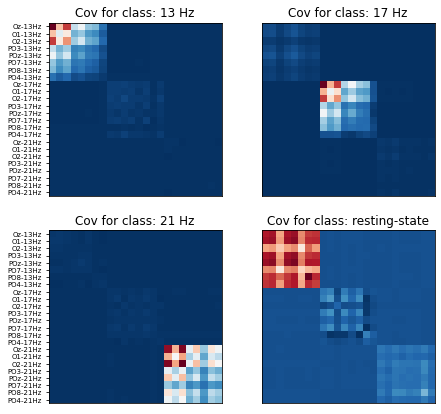

In [7]:
## Covariance matrix creation
cov = Covariances().transform(epochs_data)


# Plot Covariance matrix
plt.figure(figsize=(7, 7))
for i, l in enumerate(event_id):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(cov[events[:, -1] == event_id[l]][0],
               cmap=plt.get_cmap('RdBu_r'))
    plt.title('Cov for class: '+l)
    plt.xticks([])
    if i == 0 or i == 2:
        plt.yticks(np.arange(len(info['ch_names'])), info['ch_names'])
        ax.tick_params(axis='both', which='major', labelsize=7)
    else:
        plt.yticks([])
plt.show()

In [8]:
# Tentativa de utilizar a matriz de covariancia para fazer o predict para que dados estejam no mesmo escopo

# # Force cov matrix to be PSD
# covPSD = []
# for matrix in cov:
#     matrix = nearestPD(matrix)
#     covPSD.append(matrix)
# covPSD = np.array(covPSD)

# # Verify if matrix is PSD
# allPD = True
# for matrix in cov:
#     isMatrixPD = isPD(matrix)
#     if (not isMatrixPD):
#         allPD = False

# # Verifiy if have NaN in matrix
# print("is nan?: "+ str(np.any(np.isnan(cov))))
# # Verify if all values are finite in matrix
# print("is finite?: "+ str(np.all(np.isfinite(cov))))
# # Verify if all values in matrix fits in float precision
# fitsInFloat = True
# for matrix in cov:
#      MatrixfitsInFloat = np.all(i < np.nextafter(0, 1) for i in matrix)
#      if (not MatrixfitsInFloat):
#          fitsInFloat = False

# # Predict
# prediction = Model.predict(cov)

In [9]:
print(labels)

[1 1 1 3 4 2 3 1 2 4 2 3 1 4 3 4 2 1 4 2 3 4 1 2 3 2 4 1 3 4 3 2]


In [11]:
print(prediction_labeled)

[1 1 1 3 4 2 3 1 2 4 2 3 1 4 3 4 2 1 4 2 3 4 1 2 3 2 4 1 3 4 3 2]
